In [2]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
import os

# settings
iM_investgiate = 'ArgR'
regulator = 'argR'

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

iM_to_genes = {}
k_to_iM = {}
f = open('../data/precise_1.0/iM_table.csv', 'r')
lines = f.readlines()
f.close()
k_to_iM = {line.split(',')[0] : line.split(',')[1] for line in lines[1:]}
f = open('../data/precise_1.0/gene_presence_list.csv', 'r')
lines = f.readlines()
f.close()
for line in lines[1:]:
    k = line.split(',')[1]
    iM = k_to_iM[k]
    gene = line.split(',')[2].replace('\n', '')
    if iM not in iM_to_genes:
        iM_to_genes.update({iM : []})
    iM_to_genes[iM].append(gene)

A = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})
all_A = pd.read_csv('../data/validation_data_sets/merged_A.csv', index_col = 0)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}
regulator = gene_to_b[regulator]

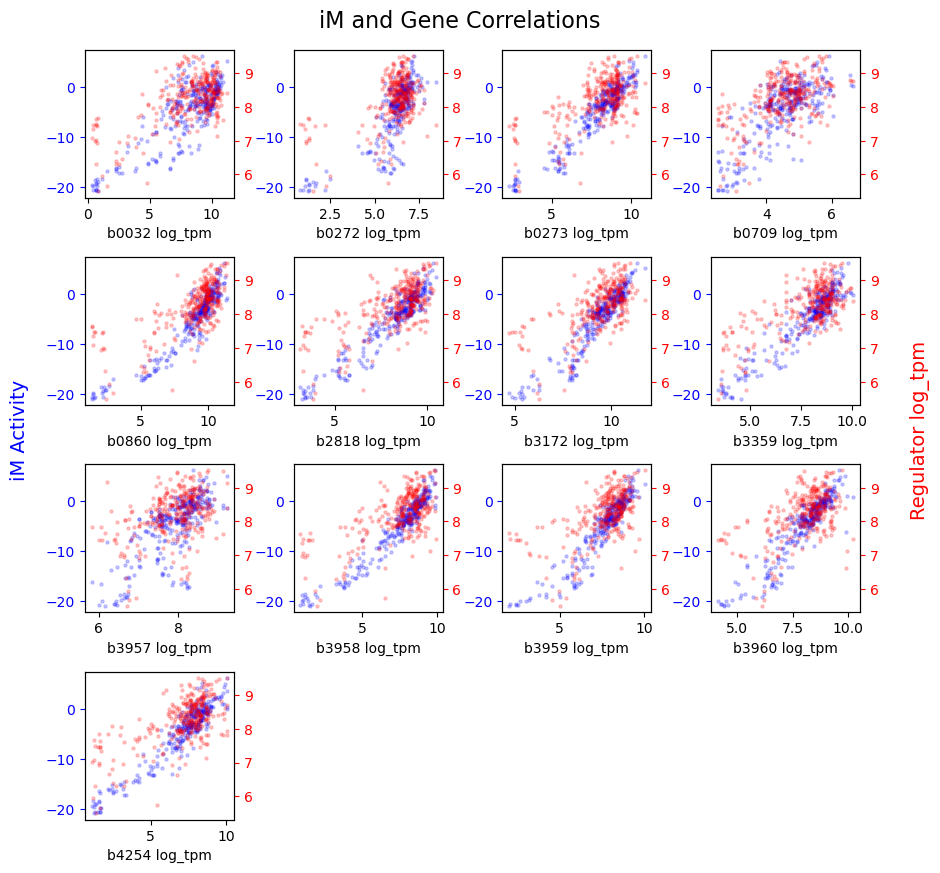

In [3]:
# sanity plotting
genes = iM_to_genes[iM_investgiate]
size = int(len(genes)**.5) + 1

# let's plot expression against iM and regulator
fig, axs = plt.subplots(size, size, figsize = (10, 10))
for gene, ax in zip(genes, axs.flatten()):
    ax.scatter(log_tpm_df.loc[gene], all_A.loc[iM_investgiate], label = gene, color = 'blue', alpha = 0.2, s = 5)
    #ax.set_ylabel(iM+' iM Activity', color = 'blue')
    ax.tick_params(axis='y', colors = 'blue')
    ax.set_xlabel(gene+' log_tpm')
    
    ax2 = ax.twinx()
    ax2.scatter(log_tpm_df.loc[gene], log_tpm_df.loc[regulator], color='r', alpha=0.2, s=5)
    #ax2.set_ylabel('Regulator log_tpm', color = 'r')
    ax2.tick_params(axis='y', colors = 'r')
    
    # Set aspect ratio to be equal
    ax.set(adjustable='datalim', aspect=np.ptp(log_tpm_df.loc[gene])/np.ptp(all_A.loc[iM_investgiate]))
    ax2.set(adjustable='datalim', aspect=np.ptp(log_tpm_df.loc[gene])/np.ptp(log_tpm_df.loc[regulator]))
    
# disappear the other axes
for ax in axs.flatten()[len(genes):]:
    ax.axis('off')

# Add one large label on the right side of all subplots
fig.text(.05, 0.5, 'iM Activity', va='center', color = 'blue', rotation='vertical', fontsize = 14)

# Add one large label on the left side of all subplots
fig.text(.95, 0.5, 'Regulator log_tpm', va='center', color = 'red', rotation='vertical', fontsize = 14)

plt.suptitle('iM and Gene Correlations', fontsize = 16, y = 0.92)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
if not os.path.exists('../figures/'+iM_investgiate):
    os.mkdir('../figures/'+iM_investgiate)
plt.savefig('../figures/'+iM_investgiate+'/iM_regulator_gene_correlations.pdf', transparent = True)
plt.show()

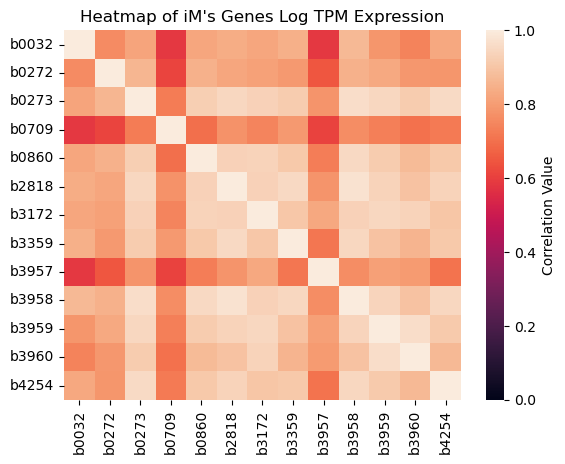

In [4]:
# now let's heatmap the genes
heat_map = sns.heatmap(log_tpm_df.loc[genes].T.corr(), vmin = 0, vmax = 1)
plt.title('Heatmap of iM\'s Genes Log TPM Expression')
color_bar = heat_map.collections[0].colorbar
color_bar.set_label('Correlation Value')
plt.savefig('../figures/'+iM_investgiate+'/gene_heatmap.pdf', transparent = True)
plt.show()